## Лабораторная работа № 1
### Изучение принципов работы байесовских сетей c использованием фреймворка Pyro и библиотеки ArviZ

#### Задачи работы:
1. Познакомиться с байесовским моделированием и организацией байесовских сетей.
2. Изучить принципы создания байесовских моделей для решения стандартных задач машинного обучения.
3. Познакомиться с байесовским подходом к заполнению пропусков в данных.
4. Получить навыки создания и обучения моделей, а также получения результатов предсказания на их основе, с использованием фреймворка Pyro.
5. Получить навыки интерпретации байесовских моделей с использованием библиотеки ArviZ.

Устанавливаем фреймворк вероятностного программирования [Pyro](https://pyro.ai/):

In [1]:
!pip install pyro-ppl

In [2]:
!pip install graphviz

In [3]:
!pip install arviz

In [4]:
!pip install seaborn

In [4]:
!pip install scikit-learn
#!pip install sklearn.compose
#!pip install sklearn.preprocessing

In [5]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126


In [6]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Подключаем библиотеки анализа и визуализации данных, необходимые в процессе работы.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import torch
import pyro
from pyro import distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

%matplotlib inline

c:\Users\User\anaconda3\envs\Efr-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Уточняем версию фреймворка Pyro. На момент написания работы, самая свежая версия -- __1.9.1__.

In [8]:
pyro.__version__

'1.9.1'

В работе анализируется датасет квартир, который содержит о них полную информацию.

Данный датасет был разделен на две части (train и predict), предназначенные для обучения байесовской модели и получения по ней предсказаний соответственно.


In [9]:
df_train_name = "epc_cut_5.csv"
df_train = pd.read_csv(df_train_name)
df_train

,Unnamed: 0,LMK_KEY,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,...,LOCAL_AUTHORITY_LABEL,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE
0,0,0003352408dad177e827f77c62ed7172f2f16336c44dcd...,21 HERIOT GRANGE,HARTLEPOOL,NaN,TS25 3JH,10000150044,E,B,53,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1983-1990,2021-08-06 07:35:31,Rented (social),5.0,NaN,1.001108e+11,Energy Assessor
1,1,1514938939222017012914223649268943,"9, Sea View Terrace",NaN,NaN,TS24 0ET,4423379478,D,B,66,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1950-1966,2017-01-29 14:22:36,owner-occupied,NaN,NaN,1.001100e+11,Address Matched
2,2,1451865729102016060917325243560118,"54, Chatham Road",NaN,NaN,TS24 8QQ,134825478,D,B,61,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1930-1949,2016-06-09 17:32:52,owner-occupied,NaN,NaN,1.001100e+11,Address Matched
3,3,142065249242010020920181950000618,"10, Kendal Road",NaN,NaN,TS25 1QY,2295640568,D,C,62,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1930-1949,2010-02-09 20:18:19,rental (private),NaN,NaN,1.001100e+11,Address Matched
4,4,978835396212019052007505697910817,"19, Wainwright Walk",NaN,NaN,TS25 1XA,8777671178,D,C,65,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1967-1975,2019-05-20 07:50:56,owner-occupied,NaN,NaN,1.001100e+11,Address Matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,790705109962012051806302878138762,"16, Zetland Road",NaN,NaN,TS26 8PZ,6712058968,E,B,52,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1950-1966,2012-05-18 06:30:28,owner-occupied,10.0,2.0,1.001100e+11,Address Matched
4996,4996,1116557159962014041111505221498894,3 Reef House,Harbour Walk,NaN,TS24 0XT,9297551278,C,C,77,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1991-1995,2014-04-11 11:50:52,rental (social),8.0,5.0,1.000971e+10,Address Matched
4997,4997,1466540409222016072809161556238176,"18, Fraser Court",NaN,NaN,TS25 4EX,7592036478,D,B,67,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1991-1995,2016-07-28 09:16:15,rental (social),NaN,NaN,1.001100e+11,Address Matched
4998,4998,1332026156532015061618405153978808,"27, South Road",NaN,NaN,TS26 9HD,5863876378,E,C,41,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: before 1900,2015-06-16 18:40:51,owner-occupied,NaN,NaN,1.001108e+11,Address Matched


Описание столбцов датасета представлено ниже.

Выделим нужные столбцы для анализа

| Название столбца          | Расшифровка |  Тип признака и его характеристики
| ------------------------- | ------------- | ------------------ |
| CURRENT_ENERGY_EFFICIENCY | Эффективность энергии | Количественный |
| PROPERTY_TYPE             | Тип квартиры | Категориальный |
| ENERGY_CONSUMPTION_CURRENT| Потребление энергии | Количественный    
| HEATING_COST_CURRENT      | Затраты на обогрев | Количественный |
| HOT_WATER_COST_CURRENT    | Затраты на горячую воду | Количественный |
| TOTAL_FLOOR_AREA          | Площадь | Количественный |
| NUMBER_HABITABLE_ROOMS    | Количество обитаемых комнат | Количественный |

В датасете наблюдаются признаки:

* **количественные**: Эффективность энергии, Потребление энергии, Затраты на обогрев, Затраты на горячую воду, Площадь, Количество обитаемых комнат
* **категориальные**: Тип квартиры.

In [10]:
df_train = df_train[
    ["CURRENT_ENERGY_EFFICIENCY", "PROPERTY_TYPE", "ENERGY_CONSUMPTION_CURRENT", "HEATING_COST_CURRENT",
     "HOT_WATER_COST_CURRENT", "TOTAL_FLOOR_AREA", "NUMBER_HEATED_ROOMS",
     ]
]

NUMBER_HEATED_ROOMS предугадываем

Посмотрим, содержат ли столбцы пропущенные значения.

In [11]:
pd.options.display.max_rows = 100
df_train.isnull().sum()

CURRENT_ENERGY_EFFICIENCY       0
PROPERTY_TYPE                   0
ENERGY_CONSUMPTION_CURRENT      0
HEATING_COST_CURRENT            1
HOT_WATER_COST_CURRENT          1
TOTAL_FLOOR_AREA                0
NUMBER_HEATED_ROOMS           408
dtype: int64

Удаляем пропущенные значения столбцов HEATING_COST_CURRENT и
HOT_WATER_COST_CURRENT

In [12]:
df_train = df_train.dropna(subset=['HEATING_COST_CURRENT','HOT_WATER_COST_CURRENT'])
df_train.isnull().sum()

CURRENT_ENERGY_EFFICIENCY       0
PROPERTY_TYPE                   0
ENERGY_CONSUMPTION_CURRENT      0
HEATING_COST_CURRENT            0
HOT_WATER_COST_CURRENT          0
TOTAL_FLOOR_AREA                0
NUMBER_HEATED_ROOMS           407
dtype: int64

Видно, что не везде указаны отопление квартир. Пропущенные значения будем заполнять в дальнейшем __с применением байесовской модели__.

Посмотрим на статистику данных.

In [13]:
df_train.describe()

,CURRENT_ENERGY_EFFICIENCY,ENERGY_CONSUMPTION_CURRENT,HEATING_COST_CURRENT,HOT_WATER_COST_CURRENT,TOTAL_FLOOR_AREA,NUMBER_HEATED_ROOMS
count,4999.000000,4999.000000,4999.00000,4999.000000,4999.000000,4592.000000
mean,63.753551,271.081416,721.34827,124.017203,87.113117,4.217988
std,13.355816,119.908003,541.46156,68.914354,47.460494,1.640852
min,1.000000,-41.000000,33.00000,0.000000,0.000000,0.000000
25%,57.000000,196.000000,406.00000,90.000000,62.540000,3.000000
50%,65.000000,255.000000,592.00000,105.000000,78.470000,4.000000
75%,72.000000,332.000000,847.00000,129.000000,96.000000,5.000000
max,106.000000,1811.000000,7502.00000,855.000000,1044.000000,14.000000


Квартиры с площадью равной 0 вызывают подозрения

Избавимся от этих строк

In [14]:
df_train = df_train[df_train.TOTAL_FLOOR_AREA != 0]
df_train.describe()

,CURRENT_ENERGY_EFFICIENCY,ENERGY_CONSUMPTION_CURRENT,HEATING_COST_CURRENT,HOT_WATER_COST_CURRENT,TOTAL_FLOOR_AREA,NUMBER_HEATED_ROOMS
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4592.000000
mean,63.749100,271.113645,721.462385,124.028611,87.130547,4.217988
std,13.353444,119.898344,541.455613,68.916528,47.449239,1.640852
min,1.000000,-41.000000,33.000000,0.000000,3.410000,0.000000
25%,57.000000,196.000000,406.250000,90.000000,62.570000,3.000000
50%,65.000000,255.000000,592.500000,105.000000,78.535000,4.000000
75%,72.000000,332.000000,847.000000,129.000000,96.000000,5.000000
max,106.000000,1811.000000,7502.000000,855.000000,1044.000000,14.000000


Посмотрим на количество значений категориальных признаков.

In [15]:
for col in ["PROPERTY_TYPE"]:
    print(df_train[col].value_counts(), end="\n\n")

PROPERTY_TYPE
House         3639
Flat           880
Bungalow       451
Maisonette      28
Name: count, dtype: int64



Количество различных значений категориальных столбцов невелико, специальным образом обрабатывать их не нужно.

Построим гистограммы количественных признаков.

<Axes: >

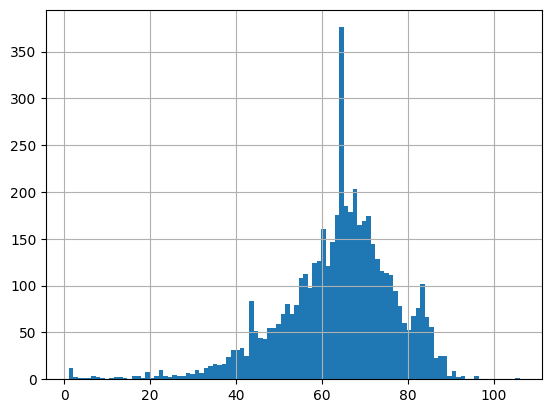

In [16]:
df_train["CURRENT_ENERGY_EFFICIENCY"].hist(bins=100)

<Axes: >

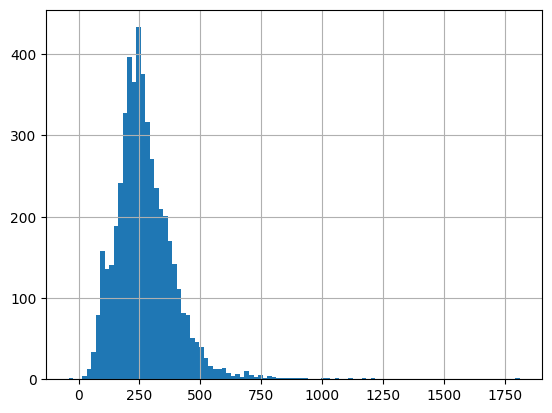

In [17]:
df_train["ENERGY_CONSUMPTION_CURRENT"].hist(bins=100)

<Axes: >

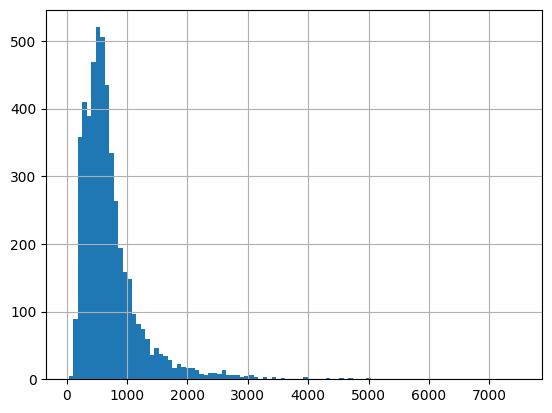

In [18]:
df_train[df_train["HEATING_COST_CURRENT"] < 500000]["HEATING_COST_CURRENT"].hist(bins=100)

<Axes: >

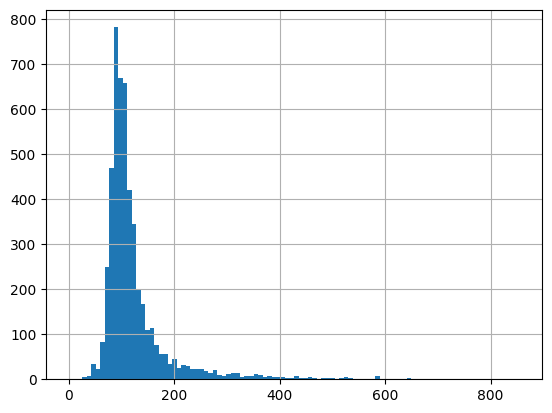

In [19]:
df_train["HOT_WATER_COST_CURRENT"].hist(bins=100)

<Axes: >

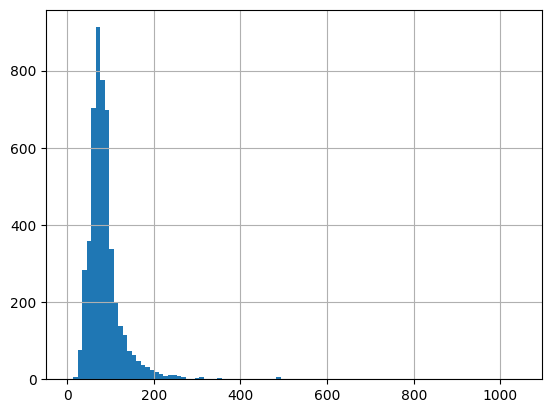

In [20]:
df_train["TOTAL_FLOOR_AREA"].hist(bins=100)

<Axes: >

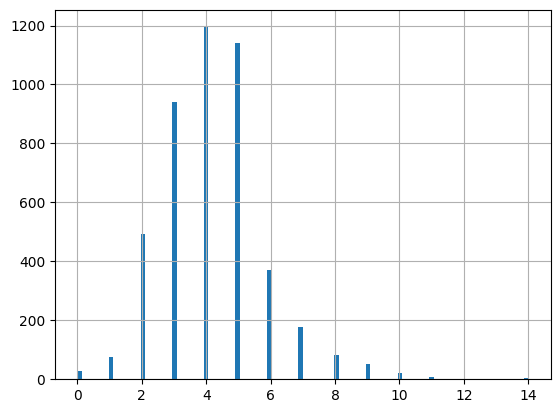

In [21]:
df_train["NUMBER_HEATED_ROOMS"].hist(bins=100)

Приведем типы столбцов датасета к корректным.

In [22]:
PROPERTY_TYPE_cat = pd.CategoricalDtype(
    categories=["House","Flat","Bungalow","Maisonette","Park home"],
    ordered=False
)

In [19]:
df_train = df_train.astype(
    {
        "CURRENT_ENERGY_EFFICIENCY": np.float64,
        "PROPERTY_TYPE": PROPERTY_TYPE_cat,
        "ENERGY_CONSUMPTION_CURRENT": np.float64,
        "HEATING_COST_CURRENT": np.float64,
        "HOT_WATER_COST_CURRENT": np.float64,
        "TOTAL_FLOOR_AREA": np.float64,
        "NUMBER_HEATED_ROOMS": np.float64,
    }

)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19981 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   CURRENT_ENERGY_EFFICIENCY   19981 non-null  float64 
 1   PROPERTY_TYPE               19981 non-null  category
 2   ENERGY_CONSUMPTION_CURRENT  19981 non-null  float64 
 3   HEATING_COST_CURRENT        19981 non-null  float64 
 4   HOT_WATER_COST_CURRENT      19981 non-null  float64 
 5   TOTAL_FLOOR_AREA            19981 non-null  float64 
 6   NUMBER_HEATED_ROOMS         18236 non-null  float64 
dtypes: category(1), float64(6)
memory usage: 1.1 MB


Выполним кодирование категориальных признаков и стандартизацию количественных.

Признак с процентной ставкой, пустые значения в котором будем заполнять с помощью байесовской модели, оставим без изменений.

In [23]:
num_features = ["CURRENT_ENERGY_EFFICIENCY", "ENERGY_CONSUMPTION_CURRENT", "HEATING_COST_CURRENT",
                "HOT_WATER_COST_CURRENT","TOTAL_FLOOR_AREA","NUMBER_HEATED_ROOMS"]
cat_features = ["PROPERTY_TYPE"]

column_transformer = ColumnTransformer([
    ("cat_transformer", OrdinalEncoder(dtype='int'), cat_features),
    ("num_transformer", StandardScaler(), num_features)
], remainder='passthrough', verbose_feature_names_out=False)

In [24]:
column_transformer.set_output(transform="pandas")
df_train = column_transformer.fit_transform(df_train)
df_train

,PROPERTY_TYPE,CURRENT_ENERGY_EFFICIENCY,ENERGY_CONSUMPTION_CURRENT,HEATING_COST_CURRENT,HOT_WATER_COST_CURRENT,TOTAL_FLOOR_AREA,NUMBER_HEATED_ROOMS
0,1,-0.805049,2.151090,-1.112783,6.660482,-1.077692,-1.351876
1,2,0.168580,-0.351280,-0.102442,-0.247115,0.018326,0.476641
2,2,-0.205893,0.099147,0.547722,0.188238,0.482025,1.086147
3,2,-0.130998,0.466161,-0.242819,-0.508327,-0.399426,-0.132865
4,2,0.093686,-0.276209,0.608675,-0.392233,1.198652,1.086147
...,...,...,...,...,...,...,...
4995,2,-0.879943,0.441137,-0.146772,2.843890,-0.044906,0.476641
4996,1,0.992420,-0.017630,-0.852348,0.130191,-0.613992,-0.742370
4997,0,0.243475,-0.159431,-0.445995,-0.464791,-0.613992,-0.742370
4998,2,-1.703783,1.008341,3.523333,-0.160045,2.126052,0.476641


Создадим функцию, преобразующую данные в датафрейме в тензоры PyTorch.

In [25]:
def convert_df_to_tensors(data: pd.DataFrame) -> dict[str, torch.Tensor]:
    tensors: dict[str, torch.Tensor] = {}
    for column in data.columns:
        tensors[column] = torch.tensor(data[column].values)
    return tensors

Поставим __задачу классификации__ (LOAN_INT_RATE == NUMBER_HEATED_ROOMS) следующим образом: предсказать вероятность PROPERTY_TYPE по его характеристикам, представленным в датасете. Одновременно с решением задачи классификации следует заполнить пропуски в столбце "NUMBER_HEATED_ROOMS". Требуется визуализовать априорные и апостериорные распределения коэффициентов байесовской модели, а также распределение целевой переменной для произвольного объекта тестового датасета.

Байесовскую модель зададим следующим образом. Курсивом обозначены случайные переменные, прямым шрифтом -- признаки из датасета.

$p(PROPERTY\_TYPE, NUMBER\_HEATED\_ROOMS, b\_CURRENT\_ENERGY\_EFFICIENCY, b\_ENERGY\_CONSUMPTION\_CURRENT, b\_HEATING\_COST\_CURRENT, b\_HOT\_WATER\_COST\_CURRENT, b\_TOTAL\_FLOOR\_AREA, b\_NUMBER\_HEATED\_ROOMS, mu\_NUMBER\_HEATED\_ROOMS, std\_NUMBER\_HEATED\_ROOMS) =
p(PROPERTY\_TYPE, NUMBER\_HEATED\_ROOMS \; | \; b\_CURRENT\_ENERGY\_EFFICIENCY, b\_ENERGY\_CONSUMPTION\_CURRENT, b\_HEATING\_COST\_CURRENT, b\_HOT\_WATER\_COST\_CURRENT, b\_TOTAL\_FLOOR\_AREA, b\_NUMBER\_HEATED\_ROOMS, mu\_NUMBER\_HEATED\_ROOMS, std\_NUMBER\_HEATED\_ROOMS) \cdot p(mu\_NUMBER\_HEATED\_ROOMS) \cdot p(std\_NUMBER\_HEATED\_ROOMS) \cdot p(b\_CURRENT\_ENERGY\_EFFICIENCY) \cdot p(b\_ENERGY\_CONSUMPTION\_CURRENT) \cdot p(b\_HEATING\_COST\_CURRENT) \cdot p(b\_HOT\_WATER\_COST\_CURRENT) \cdot p(b\_TOTAL\_FLOOR\_AREA) \cdot p(b\_NUMBER\_HEATED\_ROOMS)$

<p>&nbsp;</p>

$p(PROPERTY\_TYPE, NUMBER\_HEATED\_ROOMS \; | \; b\_CURRENT\_ENERGY\_EFFICIENCY, b\_ENERGY\_CONSUMPTION\_CURRENT, b\_HEATING\_COST\_CURRENT, b\_HOT\_WATER\_COST\_CURRENT, b\_TOTAL\_FLOOR\_AREA, b\_NUMBER\_HEATED\_ROOMS, mu\_NUMBER\_HEATED\_ROOMS, std\_NUMBER\_HEATED\_ROOMS) = \prod_{i=1}^{N} p(PROPERTY\_TYPE_i \; | \; NUMBER\_HEATED\_ROOMS, b\_CURRENT\_ENERGY\_EFFICIENCY, b\_ENERGY\_CONSUMPTION\_CURRENT, b\_HEATING\_COST\_CURRENT, b\_HOT\_WATER\_COST\_CURRENT, b\_TOTAL\_FLOOR\_AREA, b\_NUMBER\_HEATED\_ROOMS) \cdot p(NUMBER\_HEATED\_ROOMS_i \; | \; mu\_NUMBER\_HEATED\_ROOMS, std\_NUMBER\_HEATED\_ROOMS)$

<p>&nbsp;</p>

$p(PROPERTY\_TYPE_i \; | \; NUMBER\_HEATED\_ROOMS, b\_CURRENT\_ENERGY\_EFFICIENCY, b\_ENERGY\_CONSUMPTION\_CURRENT, b\_HEATING\_COST\_CURRENT, b\_HOT\_WATER\_COST\_CURRENT, b\_TOTAL\_FLOOR\_AREA, b\_NUMBER\_HEATED\_ROOMS) = \mathcal B \left[ {\sigma(logits_i)} \right]$

<p>&nbsp;</p>

$logits_i = b\_CURRENT\_ENERGY\_EFFICIENCY \cdot \text{CURRENT_ENERGY_EFFICIENCY}_i + b\_ENERGY\_CONSUMPTION\_CURRENT \cdot \text{ENERGY_CONSUMPTION_CURRENT}_i + b\_HEATING\_COST\_CURRENT \cdot \text{HEATING_COST_CURRENT}_i + b\_HOT\_WATER\_COST\_CURRENT \cdot \text{HOT_WATER_COST_CURRENT}_i + b\_TOTAL\_FLOOR\_AREA \cdot \text{TOTAL_FLOOR_AREA}_i + b\_NUMBER\_HEATED\_ROOMS \cdot NUMBER\_HEATED\_ROOMS_i$

<p>&nbsp;</p>

$p(NUMBER\_HEATED\_ROOMS_i \; | \; mu\_NUMBER\_HEATED\_ROOMS, std\_NUMBER\_HEATED\_ROOMS) = \mathcal{N}(mu\_NUMBER\_HEATED\_ROOMS, \, std\_NUMBER\_HEATED\_ROOMS)$

<p>&nbsp;</p>

$b\_CURRENT\_ENERGY\_EFFICIENCY \sim \mathcal{N}(0,\,1)$

$b\_ENERGY\_CONSUMPTION\_CURRENT \sim \mathcal{N}(0,\,1)$

$b\_HEATING\_COST\_CURRENT \sim \mathcal{N}(0,\,1)$

$b\_NUMBER\_HEATED\_ROOMS \sim \mathcal{N}(0,\,1)$

$b\_HOT\_WATER\_COST\_CURRENT \sim \mathcal{N}(0,\,1)$

$b\_TOTAL\_FLOOR\_AREA \sim \mathcal{N}(0,\,1)$

$mu\_NUMBER\_HEATED\_ROOMS \sim \mathcal{N}(0,\,1)$

$std\_NUMBER\_HEATED\_ROOMS \sim |\mathcal{N}(0,\,1)|$

<p>&nbsp;</p>

Переменная $NUMBER\_HEATED\_ROOMS$ считается __наблюдаемой__ со значениями:

$NUMBER\_HEATED\_ROOMS_i \sim \begin{cases}
    \delta(\text{NUMBER\_HEATED\_ROOMS}_i) & \text{if NUMBER\_HEATED\_ROOMS$_i$ is not None}, \\
    impute\_NUMBER\_HEATED\_ROOMS(mu\_NUMBER\_HEATED\_ROOMS,\,std\_NUMBER\_HEATED\_ROOMS) & \text{otherwise}.
\end{cases}
$

Здесь $impute\_NUMBER\_HEATED\_ROOMS = \mathcal{N}(mu\_NUMBER\_HEATED\_ROOMS,\,std\_NUMBER\_HEATED\_ROOMS)$ -- вспомогательная случайная переменная, предназначенная для "замены" отсутствующего значения NUMBER\_HEATED\_ROOMS.


Определим __модель__ в виде следующей функции.

In [26]:
def model(data: dict[str, torch.Tensor], is_training: bool = False) -> None:
    b_CEE = pyro.sample("b_CURRENT_ENERGY_EFFICIENCY", dist.Normal(0, 1))
    b_ECC = pyro.sample("b_ENERGY_CONSUMPTION_CURRENT", dist.Normal(0, 1))
    b_HCC = pyro.sample("b_HEATING_COST_CURRENT", dist.Normal(0, 1))
    b_NHR = pyro.sample("b_NUMBER_HEATED_ROOMS", dist.Normal(0, 1))
    b_HWCC = pyro.sample("b_HOT_WATER_COST_CURRENT", dist.Normal(0, 1))
    b_TFA = pyro.sample("b_TOTAL_FLOOR_AREA", dist.Normal(0, 1))

    logits = b_CEE * data["CURRENT_ENERGY_EFFICIENCY"]
    logits += b_ECC * data["ENERGY_CONSUMPTION_CURRENT"]
    logits += b_HCC * data["HEATING_COST_CURRENT"]
    logits += b_HWCC * data["HOT_WATER_COST_CURRENT"]
    logits += b_TFA * data["TOTAL_FLOOR_AREA"]

    mu_NHR = pyro.sample("mu_NUMBER_HEATED_ROOMS", dist.Normal(0, 1))
    std_NHR = pyro.sample("std_NUMBER_HEATED_ROOMS", dist.HalfNormal(1))

    impute_NHR = pyro.sample(
        "impute_NUMBER_HEATED_ROOMS", dist.Normal(
            mu_NHR,
            std_NHR
        ).mask(False)
    )

    NHR = data["NUMBER_HEATED_ROOMS"]
    NHR = torch.where(torch.isnan(NHR),
                                impute_NHR,
                                NHR)

    logits += b_NHR * NHR

    obs = None if not is_training else data["PROPERTY_TYPE"].float()

    with pyro.plate("N", data["PROPERTY_TYPE"].shape[0]):
        pyro.sample("NUMBER_HEATED_ROOMS",
                    dist.Normal(mu_NHR, std_NHR),
                    obs=NHR)
        pyro.sample("PROPERTY_TYPE",
                    dist.Categorical(logits=logits),
                    obs=obs)

    print(logits)
    print(dist.Categorical(logits=logits))   

Визуализируем графическую вероятностную модель, соответствующую совместному распределению данных и весов.

Provenance:
frozenset({'b_HEATING_COST_CURRENT', 'b_TOTAL_FLOOR_AREA', 'b_HOT_WATER_COST_CURRENT', 'b_NUMBER_HEATED_ROOMS', 'impute_NUMBER_HEATED_ROOMS', 'b_ENERGY_CONSUMPTION_CURRENT', 'b_CURRENT_ENERGY_EFFICIENCY'})
Tensor:
tensor([-3.7936,  0.6975,  1.3020,  ..., -0.8132, -0.0516,  0.9721],
       dtype=torch.float64)
Categorical(logits: (4998,))


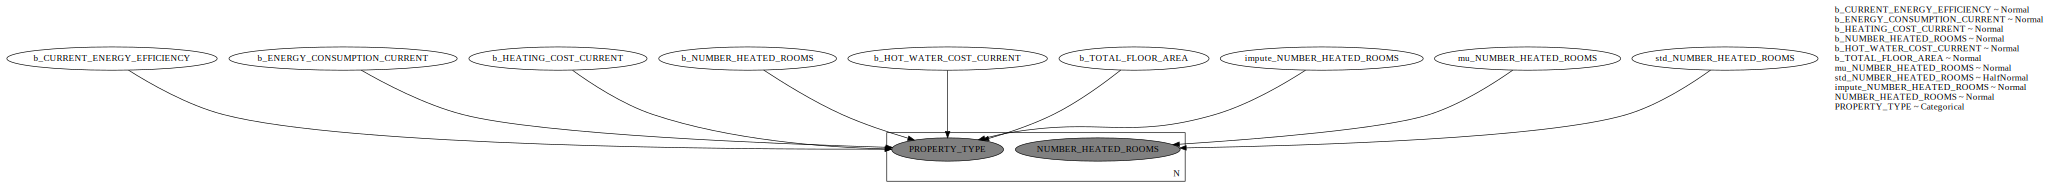

In [27]:
pyro.render_model(model,
                  model_args=(convert_df_to_tensors(df_train), True),
                  render_distributions=True,
                  render_params=True)

Посмотрим на форму всех переменных в модели.

In [28]:
trace = pyro.poutine.trace(model).get_trace(
    convert_df_to_tensors(df_train), True)
print(trace.format_shapes())

tensor([-3.7936,  0.6975,  1.3020,  ..., -0.8132, -0.0516,  0.9721],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
                    Trace Shapes:       
                     Param Sites:       
                    Sample Sites:       
 b_CURRENT_ENERGY_EFFICIENCY dist      |
                            value      |
b_ENERGY_CONSUMPTION_CURRENT dist      |
                            value      |
      b_HEATING_COST_CURRENT dist      |
                            value      |
       b_NUMBER_HEATED_ROOMS dist      |
                            value      |
    b_HOT_WATER_COST_CURRENT dist      |
                            value      |
          b_TOTAL_FLOOR_AREA dist      |
                            value      |
      mu_NUMBER_HEATED_ROOMS dist      |
                            value      |
     std_NUMBER_HEATED_ROOMS dist      |
                            value      |
  impute_NUMBER_HEATED_ROOMS dist      |
                            value      |
  

Выполним **инференс модели** с использованием марковских последовательностей Монте-Карло (MCMC).

Данная процедура выполняет нахождение апостериорного распределения весов модели, многократно сэмплируя из совместного распределения и приводя распределение сэмплов к апостериорному распределению весов.

Процедура сэмплирования может быть __достаточно длительной__.

In [29]:
num_of_samples = 400
burn_in_samples = 100

mcmc = MCMC(NUTS(model, jit_compile=True),
            num_samples=num_of_samples, warmup_steps=burn_in_samples)
mcmc.run(convert_df_to_tensors(df_train), True)
mcmc.summary()

Warmup:   0%|          | 0/500 [00:00, ?it/s]c:\Users\User\anaconda3\envs\Efr-env\Lib\site-packages\pyro\poutine\subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)


tensor([ 4.2974, -0.2528, -2.2802,  ...,  1.9167, -8.6246, -1.2100],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([ 7.3570, -0.4817, -2.1207,  ...,  0.9613, -4.8107, -1.6681],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([ 7.3570, -0.4817, -2.1207,  ...,  0.9613, -4.8107, -1.6681],
       dtype=torch.float64, grad_fn=<AddBackward0>)
Categorical(logits: torch.Size([4998]))
tensor([ 7.3570, -0.4817, -2.1207,  ...,  0.9613, -4.8107, -1.6681],
       dtype=torch.float64, grad_fn=<AddBackward0>)
Categorical(logits: torch.Size([4998]))


Sample: 100%|██████████| 500/500 [06:42,  1.24it/s, step size=3.02e-02, acc. prob=0.964]


                                    mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_CURRENT_ENERGY_EFFICIENCY      0.47      0.03      0.47      0.41      0.51    392.52      1.00
  b_ENERGY_CONSUMPTION_CURRENT      0.37      0.03      0.37      0.32      0.41    298.00      1.00
        b_HEATING_COST_CURRENT      0.01      0.02      0.01     -0.02      0.05    198.06      1.00
      b_HOT_WATER_COST_CURRENT      0.38      0.01      0.38      0.36      0.39     54.76      1.02
         b_NUMBER_HEATED_ROOMS      0.91      0.01      0.91      0.89      0.93    566.83      1.00
            b_TOTAL_FLOOR_AREA     -0.47      0.03     -0.47     -0.51     -0.42    233.73      1.00
    impute_NUMBER_HEATED_ROOMS     -0.46      0.04     -0.46     -0.54     -0.40    143.78      1.00
        mu_NUMBER_HEATED_ROOMS     -0.04      0.02     -0.04     -0.06     -0.01    429.71      1.00
       std_NUMBER_HEATED_ROOMS      0.97      0.01      0.97      0.95      0.98    440.41

После выполнения процедуры сэмплирования проверьте значения в сводке параметров:
* n_eff: должен быть близок к количеству семплов, определяет степень скоррелированности полученных семплов;
* r_hat: должен быть близким к единице, что указывает на сходимость метода.

Получить сэмплы из апостериорного распределения весов можно следующим образом:

In [30]:
posterior_samples = mcmc.get_samples()
posterior_samples

{'b_CURRENT_ENERGY_EFFICIENCY': tensor([0.5317, 0.3997, 0.4490, 0.4539, 0.4820, 0.4529, 0.4126, 0.4019, 0.3484,
         0.4584, 0.4601, 0.4750, 0.4662, 0.4854, 0.4762, 0.4936, 0.4148, 0.4336,
         0.5552, 0.4647, 0.4555, 0.4468, 0.4612, 0.4301, 0.4873, 0.4415, 0.4589,
         0.4761, 0.4138, 0.5219, 0.5295, 0.5219, 0.5062, 0.4338, 0.4365, 0.4239,
         0.4566, 0.4668, 0.4716, 0.4890, 0.4850, 0.4312, 0.4499, 0.4353, 0.5171,
         0.4275, 0.4636, 0.4685, 0.5676, 0.5096, 0.4202, 0.5008, 0.4858, 0.4968,
         0.4553, 0.4524, 0.4471, 0.4756, 0.4825, 0.4573, 0.4455, 0.4600, 0.4491,
         0.4691, 0.4185, 0.4675, 0.4845, 0.4621, 0.4703, 0.5329, 0.4536, 0.4451,
         0.4935, 0.4600, 0.4762, 0.4765, 0.5053, 0.5038, 0.4909, 0.4965, 0.4546,
         0.4431, 0.4961, 0.5037, 0.4966, 0.4599, 0.5084, 0.4154, 0.4578, 0.5038,
         0.4543, 0.4774, 0.4581, 0.4686, 0.4967, 0.4704, 0.4427, 0.5288, 0.4966,
         0.4752, 0.5145, 0.4364, 0.4660, 0.4650, 0.4752, 0.4718, 0.4851, 0.477

После выполнения инференса займёмся процедурой __предсказания__ с использованием обученной модели.

Загрузим датасет с тестовыми данными и посмотрим на него.

In [31]:
df_predict_name = "epc_cut_5.csv"
df_predict = pd.read_csv(df_predict_name)
df_predict

,Unnamed: 0,LMK_KEY,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,...,LOCAL_AUTHORITY_LABEL,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE
0,0,0003352408dad177e827f77c62ed7172f2f16336c44dcd...,21 HERIOT GRANGE,HARTLEPOOL,NaN,TS25 3JH,10000150044,E,B,53,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1983-1990,2021-08-06 07:35:31,Rented (social),5.0,NaN,1.001108e+11,Energy Assessor
1,1,1514938939222017012914223649268943,"9, Sea View Terrace",NaN,NaN,TS24 0ET,4423379478,D,B,66,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1950-1966,2017-01-29 14:22:36,owner-occupied,NaN,NaN,1.001100e+11,Address Matched
2,2,1451865729102016060917325243560118,"54, Chatham Road",NaN,NaN,TS24 8QQ,134825478,D,B,61,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1930-1949,2016-06-09 17:32:52,owner-occupied,NaN,NaN,1.001100e+11,Address Matched
3,3,142065249242010020920181950000618,"10, Kendal Road",NaN,NaN,TS25 1QY,2295640568,D,C,62,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1930-1949,2010-02-09 20:18:19,rental (private),NaN,NaN,1.001100e+11,Address Matched
4,4,978835396212019052007505697910817,"19, Wainwright Walk",NaN,NaN,TS25 1XA,8777671178,D,C,65,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1967-1975,2019-05-20 07:50:56,owner-occupied,NaN,NaN,1.001100e+11,Address Matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,790705109962012051806302878138762,"16, Zetland Road",NaN,NaN,TS26 8PZ,6712058968,E,B,52,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1950-1966,2012-05-18 06:30:28,owner-occupied,10.0,2.0,1.001100e+11,Address Matched
4996,4996,1116557159962014041111505221498894,3 Reef House,Harbour Walk,NaN,TS24 0XT,9297551278,C,C,77,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1991-1995,2014-04-11 11:50:52,rental (social),8.0,5.0,1.000971e+10,Address Matched
4997,4997,1466540409222016072809161556238176,"18, Fraser Court",NaN,NaN,TS25 4EX,7592036478,D,B,67,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: 1991-1995,2016-07-28 09:16:15,rental (social),NaN,NaN,1.001100e+11,Address Matched
4998,4998,1332026156532015061618405153978808,"27, South Road",NaN,NaN,TS26 9HD,5863876378,E,C,41,...,Hartlepool,Hartlepool,HARTLEPOOL,England and Wales: before 1900,2015-06-16 18:40:51,owner-occupied,NaN,NaN,1.001108e+11,Address Matched


In [32]:
df_predict = df_predict[
    ["CURRENT_ENERGY_EFFICIENCY", "PROPERTY_TYPE", "ENERGY_CONSUMPTION_CURRENT", "HEATING_COST_CURRENT",
     "HOT_WATER_COST_CURRENT", "TOTAL_FLOOR_AREA", "NUMBER_HEATED_ROOMS",
     ]
]
df_predict = df_predict.dropna(subset=['HEATING_COST_CURRENT','HOT_WATER_COST_CURRENT'])
df_predict.isnull().sum()
df_predict = df_predict[df_predict.TOTAL_FLOOR_AREA != 0]
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4998 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CURRENT_ENERGY_EFFICIENCY   4998 non-null   int64  
 1   PROPERTY_TYPE               4998 non-null   object 
 2   ENERGY_CONSUMPTION_CURRENT  4998 non-null   int64  
 3   HEATING_COST_CURRENT        4998 non-null   float64
 4   HOT_WATER_COST_CURRENT      4998 non-null   float64
 5   TOTAL_FLOOR_AREA            4998 non-null   float64
 6   NUMBER_HEATED_ROOMS         4592 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 312.4+ KB


Выполним над тестовым датасетом те же преобразования признаков, что и над тренировочным:

In [33]:
df_predict = column_transformer.transform(df_predict)
df_predict

,PROPERTY_TYPE,CURRENT_ENERGY_EFFICIENCY,ENERGY_CONSUMPTION_CURRENT,HEATING_COST_CURRENT,HOT_WATER_COST_CURRENT,TOTAL_FLOOR_AREA,NUMBER_HEATED_ROOMS
0,1,-0.805049,2.151090,-1.112783,6.660482,-1.077692,-1.351876
1,2,0.168580,-0.351280,-0.102442,-0.247115,0.018326,0.476641
2,2,-0.205893,0.099147,0.547722,0.188238,0.482025,1.086147
3,2,-0.130998,0.466161,-0.242819,-0.508327,-0.399426,-0.132865
4,2,0.093686,-0.276209,0.608675,-0.392233,1.198652,1.086147
...,...,...,...,...,...,...,...
4995,2,-0.879943,0.441137,-0.146772,2.843890,-0.044906,0.476641
4996,1,0.992420,-0.017630,-0.852348,0.130191,-0.613992,-0.742370
4997,0,0.243475,-0.159431,-0.445995,-0.464791,-0.613992,-0.742370
4998,2,-1.703783,1.008341,3.523333,-0.160045,2.126052,0.476641


Получим распределение наблюдаемых переменных для каждого объекта из тестовой выборки с использованием апостериорных распределений весов (полученных после обучения модели).

In [34]:
posterior_predictive = Predictive(model, posterior_samples)(
    convert_df_to_tensors(df_predict))
posterior_predictive

tensor([ 0.9299,  0.1881,  1.3730,  ..., -1.3027,  2.4685,  0.7505],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([-11.5066,   0.5669,   1.7404,  ...,  -1.1408,   5.5132,  -0.3618],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([ 2.1365,  0.2918,  0.8035,  ..., -0.5274, -1.0371,  0.5182],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([ 2.2066,  0.2853,  0.7852,  ..., -0.5185, -0.9621,  0.5664],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([ 2.1980,  0.2845,  0.7634,  ..., -0.5029, -1.0302,  0.5297],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([ 2.2458,  0.2802,  0.7917,  ..., -0.5275, -0.9711,  0.5476],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([ 2.1840,  0.2894,  0.7952,  ..., -0.5274, -1.0292,  0.5315],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([ 2.2492,  0.2856,  0.7942, 

{'PROPERTY_TYPE': tensor([[2945, 2022, 1102,  ..., 1719, 1560,  327],
         [3414, 2773, 1980,  ..., 4485, 2826, 4252],
         [3221, 4348, 1098,  ..., 2888, 2146, 4321],
         ...,
         [1560,  776, 2839,  ..., 1508, 4677, 4191],
         [ 795, 1374, 3644,  ..., 2862, 3903, 3982],
         [4379,  780, 4213,  ..., 3822, 2374,  136]]),
 'NUMBER_HEATED_ROOMS': tensor([[-1.3519,  0.4766,  1.0861,  ..., -0.7424,  0.4766,  0.4766],
         [-1.3519,  0.4766,  1.0861,  ..., -0.7424,  0.4766,  0.4766],
         [-1.3519,  0.4766,  1.0861,  ..., -0.7424,  0.4766,  0.4766],
         ...,
         [-1.3519,  0.4766,  1.0861,  ..., -0.7424,  0.4766,  0.4766],
         [-1.3519,  0.4766,  1.0861,  ..., -0.7424,  0.4766,  0.4766],
         [-1.3519,  0.4766,  1.0861,  ..., -0.7424,  0.4766,  0.4766]],
        dtype=torch.float64)}

Получим распределение наблюдаемых переменных для каждого объекта из тестовой выборки с использованием априорных распределений весов (полученных до обучения модели).

In [35]:
prior = Predictive(model, num_samples=num_of_samples)(
    convert_df_to_tensors(df_predict))
prior

tensor([ 0.9767,  0.2803,  0.2828,  ..., -0.0021, -2.0666,  0.3224],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([ 2.5217, -0.4758,  0.4833,  ..., -0.3416,  3.4247,  0.8524],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([-0.2990,  0.5260,  2.5294,  ..., -2.0787,  5.1543,  1.0832],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([15.1683, -1.4400,  1.8789,  ..., -2.5746, 11.3059,  1.9739],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([-4.9606, -0.0137,  0.1946,  ...,  0.1758,  2.7388,  0.5776],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([ 0.9962, -0.8167,  0.6212,  ..., -0.5212,  6.6908,  0.5149],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([ 9.5654, -0.4259,  0.0388,  ..., -0.5766,  0.0815, -0.2511],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([-10.6140,   0.4119,   2.0192,  ..

{'b_CURRENT_ENERGY_EFFICIENCY': tensor([[ 1.4180e-01],
         [-5.6086e-01],
         [-1.2536e+00],
         [ 4.8570e-01],
         [ 1.6530e+00],
         [-8.0436e-01],
         [ 2.5730e-01],
         [ 3.9497e-01],
         [-7.4859e-02],
         [ 5.0621e-01],
         [ 7.8135e-01],
         [ 1.5102e+00],
         [-2.0361e+00],
         [-1.8566e-01],
         [ 1.8107e+00],
         [ 9.7102e-02],
         [ 3.5564e-01],
         [ 5.5927e-01],
         [ 1.3658e+00],
         [ 5.2802e-02],
         [ 1.1844e+00],
         [-1.0836e-02],
         [ 5.9784e-01],
         [-6.5995e-02],
         [-7.1352e-01],
         [-7.6141e-01],
         [ 9.1646e-01],
         [ 2.8365e-01],
         [-8.0564e-01],
         [ 2.4762e+00],
         [-3.1676e+00],
         [-2.2514e-02],
         [ 9.9404e-01],
         [ 2.0437e-01],
         [-7.8741e-01],
         [ 1.2169e+00],
         [ 1.2667e+00],
         [-2.8594e-01],
         [-1.4744e-01],
         [ 1.6958e+00],
         

Сформируем данные для визуализации с помощью библиотеки [ArViZ](https://python.arviz.org/en/stable/).

In [36]:
pyro_data = az.from_pyro(
    mcmc, prior=prior, posterior_predictive=posterior_predictive
)
pyro_data

tensor([-7.3061,  0.5580,  3.6067,  ..., -3.2850, 13.8284,  1.2629],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([-6.3820,  0.3132,  1.7965,  ..., -1.4650,  7.2048,  0.5112],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))
tensor([-4.0065, -0.1554, -0.8153,  ...,  1.5065, -2.0099,  0.1601],
       dtype=torch.float64)
Categorical(logits: torch.Size([4998]))


c:\Users\User\anaconda3\envs\Efr-env\Lib\site-packages\arviz\data\io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Визуализируем апостериорные распределения всех латентных переменных. "Качество" формы графиков зависит, в том числе, от числа семплов. Увеличение количества семплов приводит к формированию более точных распределений, но и увеличивает расчётное время.

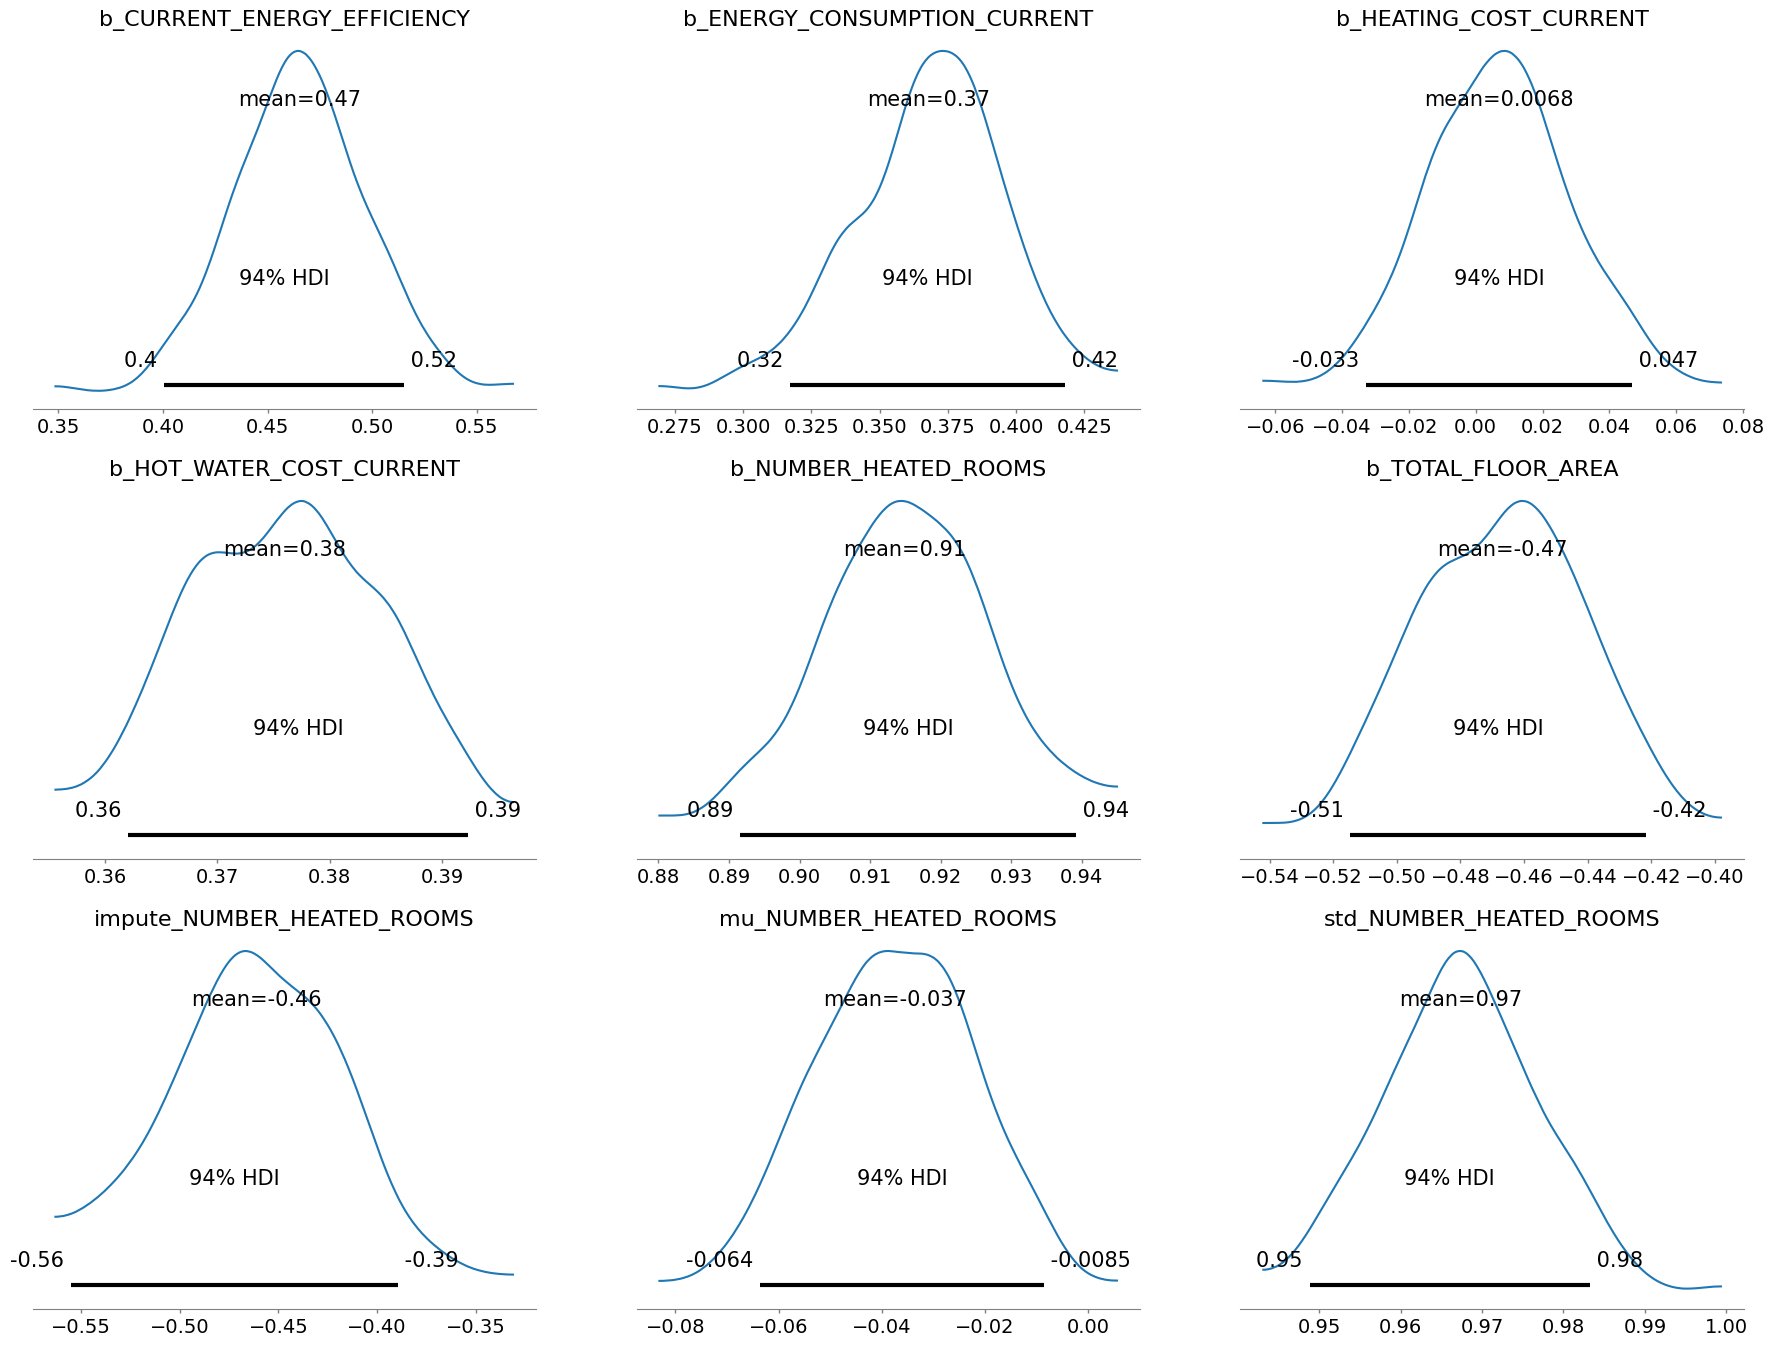

In [37]:
az.plot_posterior(pyro_data);

Визуализируем априорные и апостериорные распределения для каждой латентной переменной и сравним их.

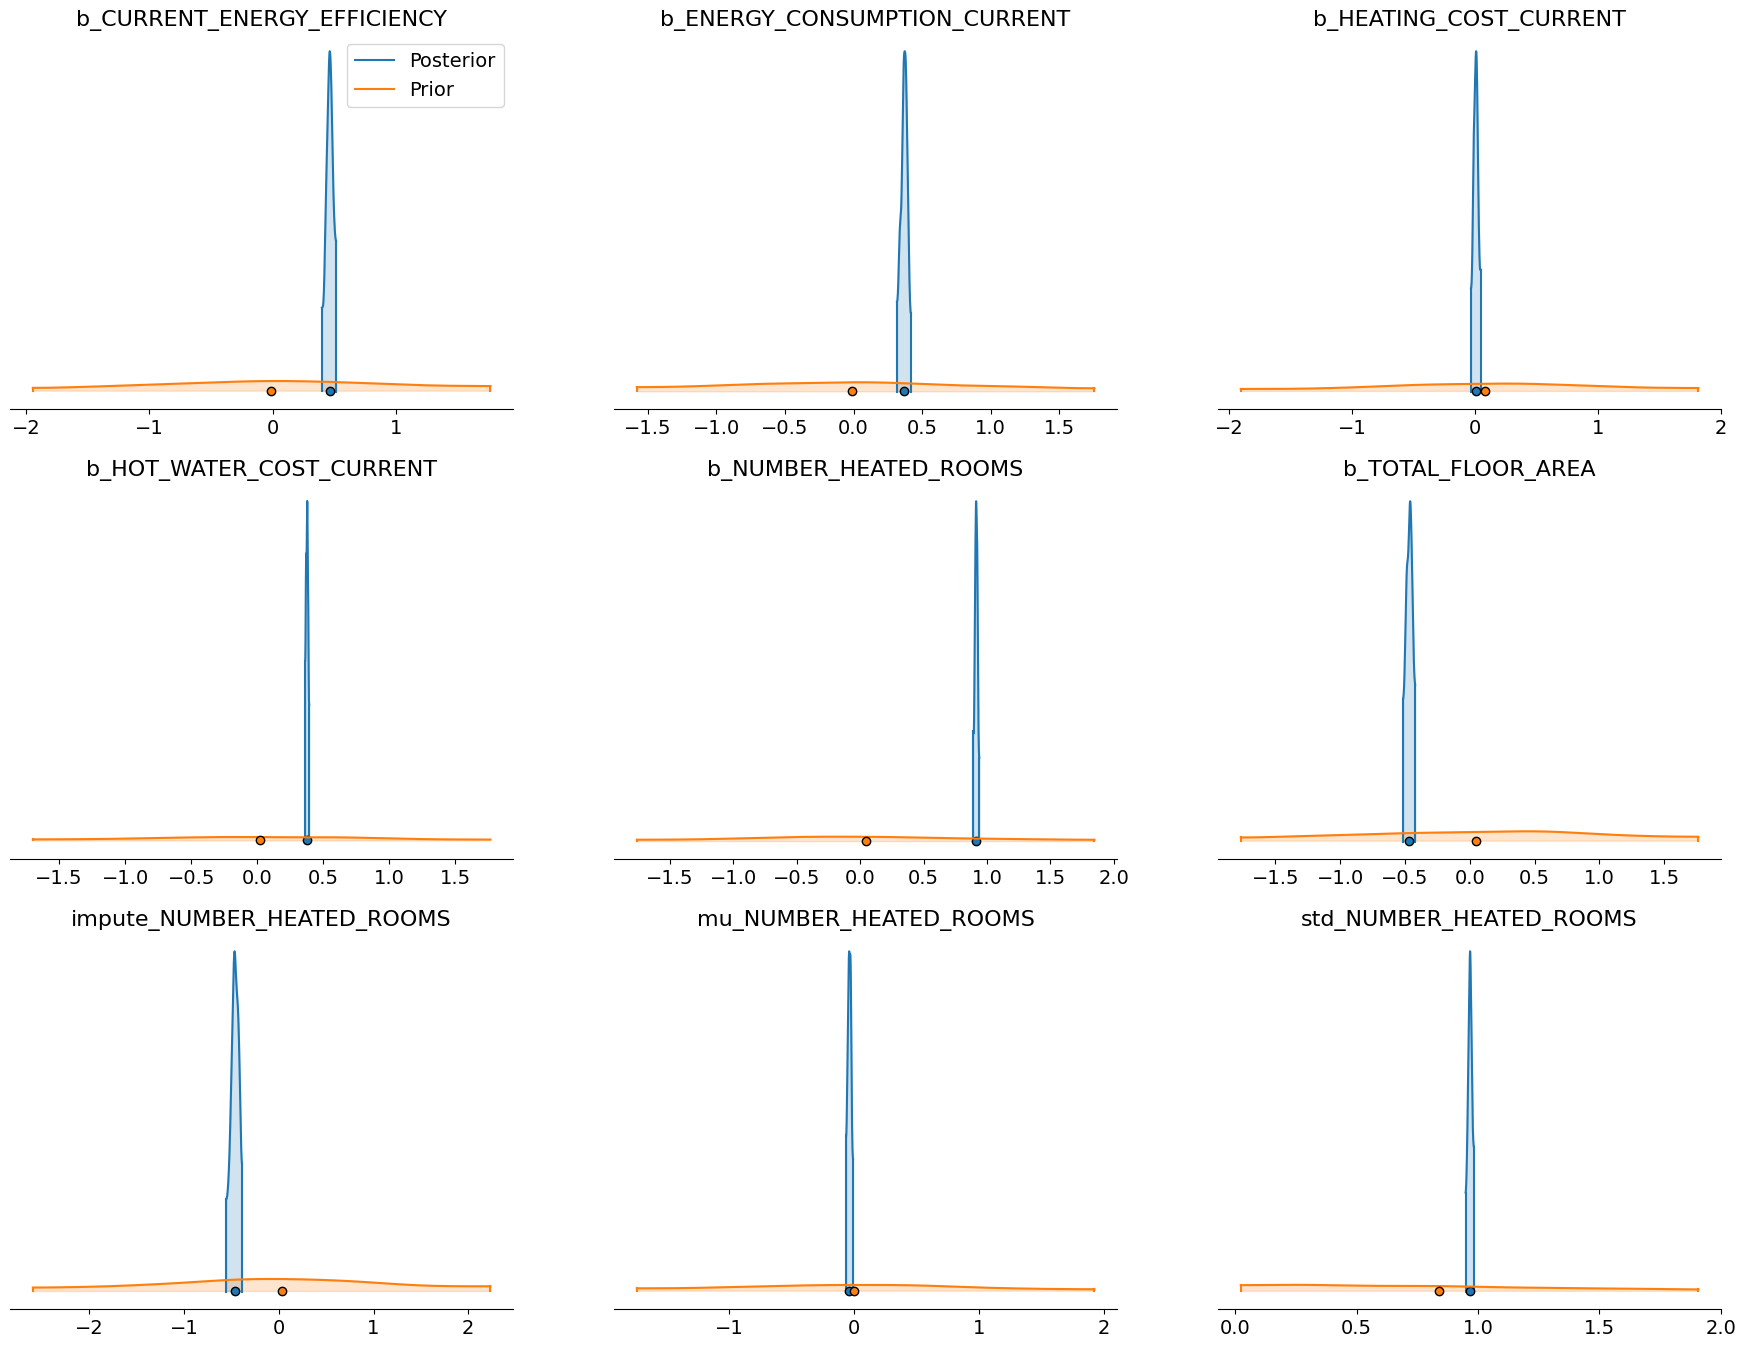

In [38]:
axes = az.plot_density(
    [pyro_data.posterior, pyro_data.prior],
    data_labels=["Posterior", "Prior"],
    shade=0.2
)

Визуализируем семейство распределений латентных переменных, полученных моделью, и сравним их с эмпирическим распределением, сформированным из тестового датасета.

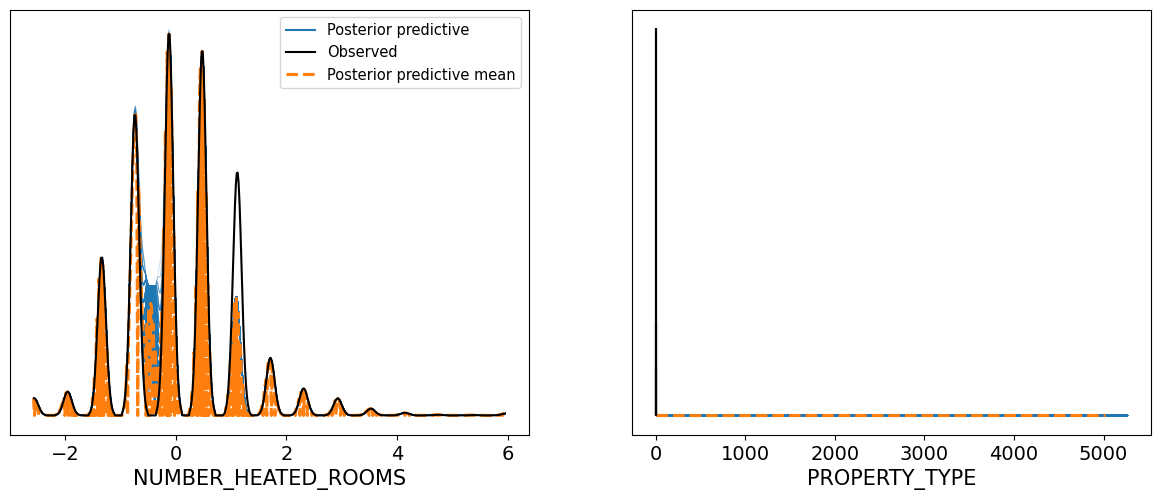

In [39]:
az.plot_ppc(pyro_data);

Посмотрим на апостериорные распределения латентных переменных (весов модели) всесте с "трассой" -- набором сэмплов, полученных в процессе выполнения инференса методом MCMC.

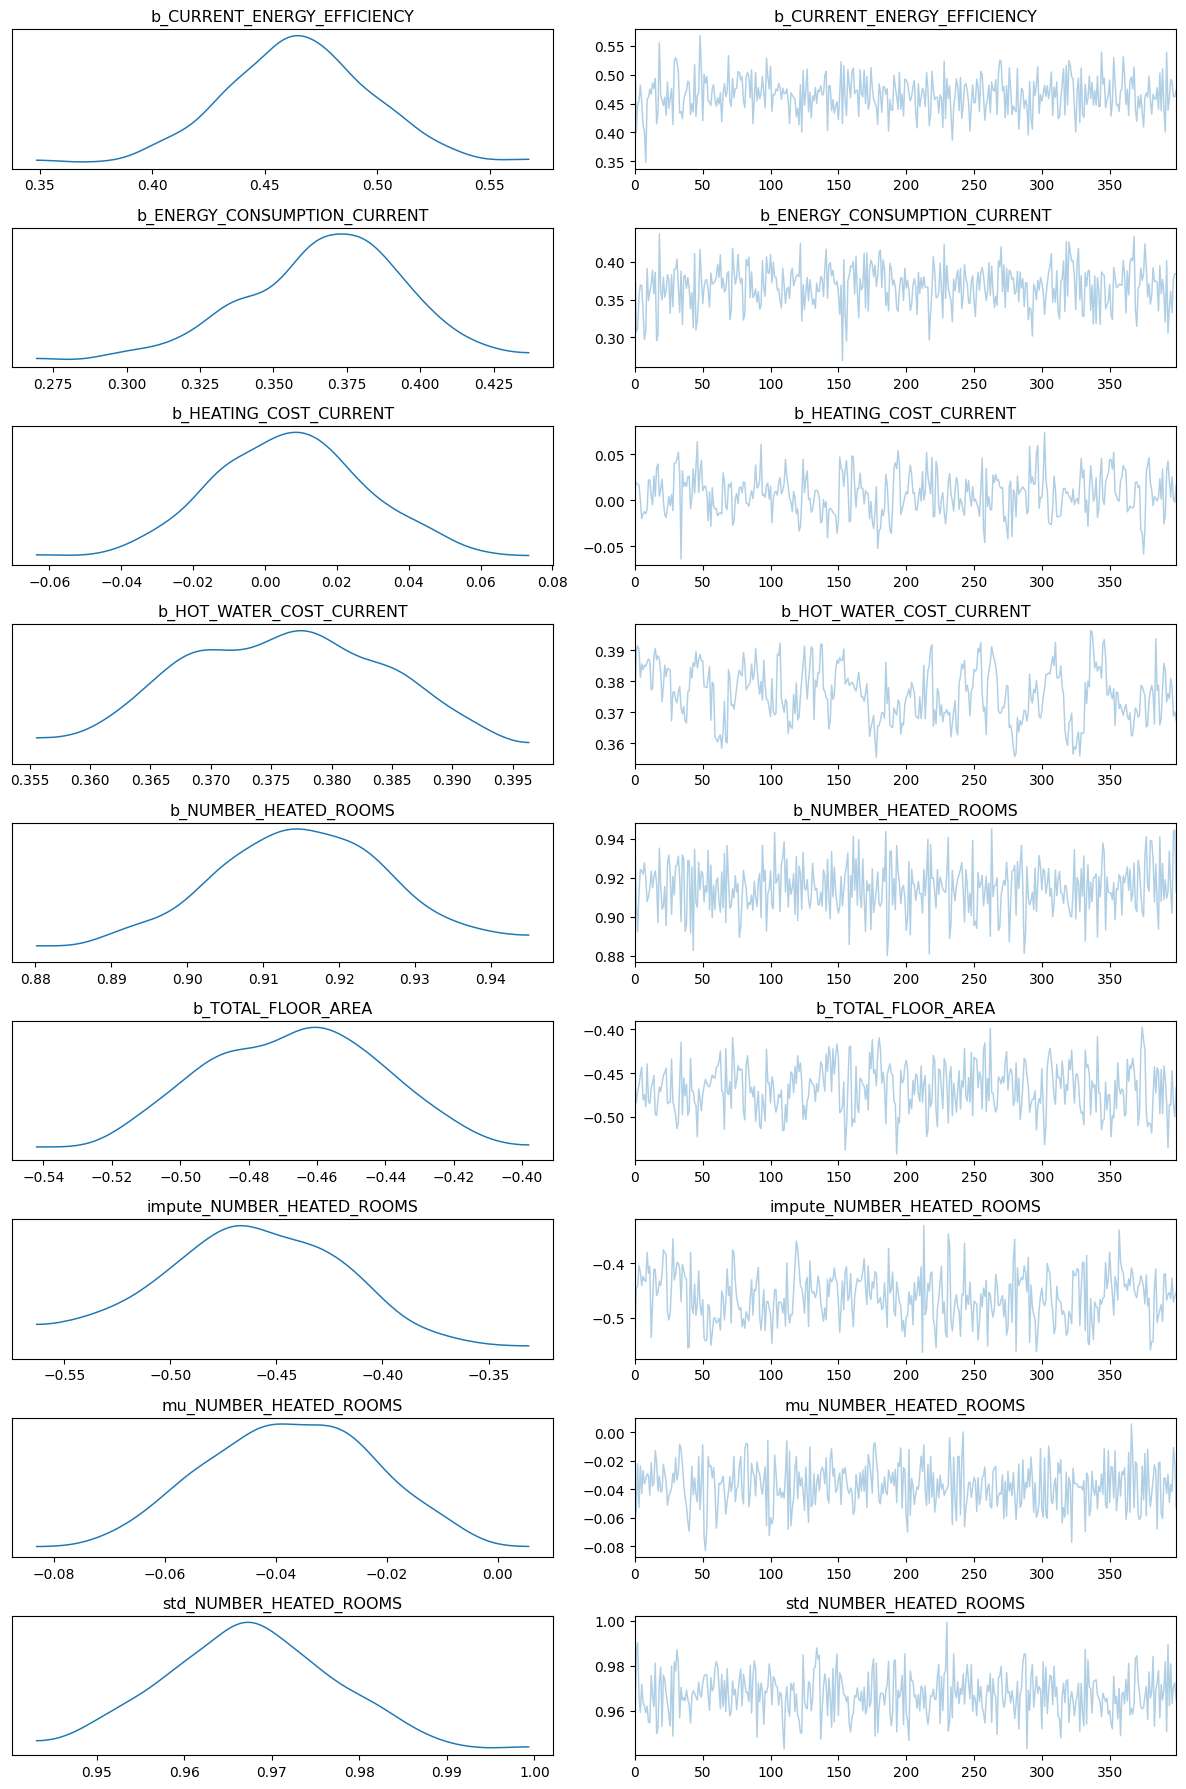

In [40]:
az.plot_trace(pyro_data)
plt.gcf().tight_layout()

Визуализируем распределение переменной статуса кредита (целевая бинарная переменная, показывающая, возвращен ли клиентом кредит) для одного случайного клиента. Красной пунктирной линией показано истинное значение целевой переменной у данного объекта.

tensor([1.0433], dtype=torch.float64)
Categorical(logits: tensor([0.], dtype=torch.float64))
tensor([-0.8055], dtype=torch.float64)
Categorical(logits: tensor([0.], dtype=torch.float64))
tensor([-0.1308], dtype=torch.float64)
Categorical(logits: tensor([0.], dtype=torch.float64))
tensor([-0.1053], dtype=torch.float64)
Categorical(logits: tensor([0.], dtype=torch.float64))
tensor([-0.0980], dtype=torch.float64)
Categorical(logits: tensor([0.], dtype=torch.float64))
tensor([-0.1193], dtype=torch.float64)
Categorical(logits: tensor([0.], dtype=torch.float64))
tensor([-0.1204], dtype=torch.float64)
Categorical(logits: tensor([0.], dtype=torch.float64))
tensor([-0.1207], dtype=torch.float64)
Categorical(logits: tensor([0.], dtype=torch.float64))
tensor([-0.1085], dtype=torch.float64)
Categorical(logits: tensor([0.], dtype=torch.float64))
tensor([-0.0967], dtype=torch.float64)
Categorical(logits: tensor([0.], dtype=torch.float64))
tensor([-0.1068], dtype=torch.float64)
Categorical(logits: te

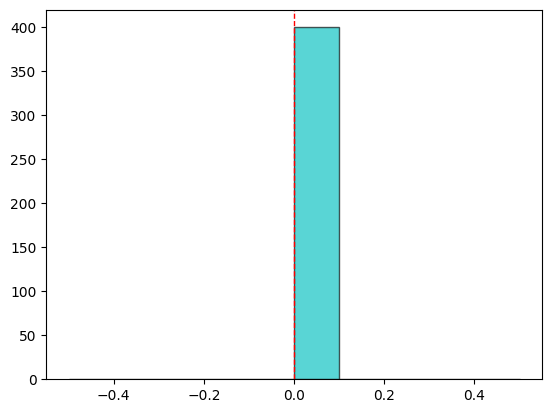

In [41]:
df_predict_one = df_predict.sample(n=1)

posterior_predictive_one = Predictive(model, posterior_samples)(
    convert_df_to_tensors(df_predict_one))
ser = pd.Series(
    posterior_predictive_one["PROPERTY_TYPE"].detach().numpy().squeeze()
)
print("Ground True value: ", df_predict_one["PROPERTY_TYPE"].values.squeeze())
print("Probability of label to be one: ", ser.mean())
print("Distribution:")
result = plt.hist(ser, color='c', edgecolor='k', alpha=0.65)
plt.axvline(ser.mean(), color='r', linestyle='dashed', linewidth=1)

Сформируем фрагмент датафрейма с результатами предсказаний.

In [42]:
df_result = df_predict.copy()

In [46]:
pred_mean = posterior_predictive['PROPERTY_TYPE'].numpy().mean(axis=0)
pred_std  = posterior_predictive['PROPERTY_TYPE'].numpy().std(axis=0)

df_result["PROPERTY_TYPE_pred"] = [
    f"{mean:.2f} ± {std:.2f}" for mean, std in zip(pred_mean, pred_std)
]

loan_mean = posterior_predictive['NUMBER_HEATED_ROOMS'].numpy().mean(axis=0)
loan_std  = posterior_predictive['NUMBER_HEATED_ROOMS'].numpy().std(axis=0)

df_result["NUMBER_HEATED_ROOMS_pred"] = [
    f"{mean:.2f} ± {std:.2f}" for mean, std in zip(loan_mean, loan_std)
]

df_result[["NUMBER_HEATED_ROOMS",
           "NUMBER_HEATED_ROOMS_pred",
           "PROPERTY_TYPE",
           "PROPERTY_TYPE_pred"]]

,NUMBER_HEATED_ROOMS,NUMBER_HEATED_ROOMS_pred,PROPERTY_TYPE,PROPERTY_TYPE_pred
0,-1.35 ± 0.00,-1.35 ± 0.00,1,2455.55 ± 1354.87
1,0.48 ± 0.00,0.48 ± 0.00,2,2510.07 ± 1425.96
2,1.09 ± 0.00,1.09 ± 0.00,2,2535.81 ± 1373.82
3,-0.13 ± 0.00,-0.13 ± 0.00,2,2411.94 ± 1409.82
4,1.09 ± 0.00,1.09 ± 0.00,2,2525.43 ± 1378.21
...,...,...,...,...
4995,0.48 ± 0.00,0.48 ± 0.00,2,2607.06 ± 1399.68
4996,-0.74 ± 0.00,-0.74 ± 0.00,1,2596.59 ± 1377.71
4997,-0.74 ± 0.00,-0.74 ± 0.00,0,2506.66 ± 1409.49
4998,0.48 ± 0.00,0.48 ± 0.00,2,2367.19 ± 1417.09


Данные результаты позволяют получить представление о качестве работы модели.

### Индивидуальное задание

Опираясь на представленное исследование и используя его в качестве образца, **выполните аналогичные действия с выбранным Вами датасетом**.

В процессе работы:

1. Выберите датасет, содержащий табличные данные. Датасеты можно найти, например, на [Kaggle](https://www.kaggle.com/datasets) и [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). __Хотя бы один столбец__ датасета (*количественный!*) должен содержать пропуски.
2. Выполните __разведочный анализ__ датасета, выполните требуемые __преобразования признаков__.
3. Разделите датасет на __обучающую__ и __тестовую__ части.
4. Поставьте задачу __классификации__ или __регрессии__ для данных из датасета.
5. Составьте __байесовскую модель__ для решения поставленной задачи и определения пропущенных данных. Запишите совместное распределение наблюдаемых и латентных переменных (данных и весов соответственно), выражения правдоподобия и априорных распределений.
6. __Запрограммируйте__ модель с использованием библиотеки Pyro. Получите изображение __графической вероятностной модели__, сформированной Pyro.
7. __Обучите__ вероятностную модель с использованием MCMC.
8. __Визуализируйте__ априорные и апостериорные распределения весов модели, а также "трассы", полученные в процессе сэмплирования. Критически оцените полученный результат.
9. __Визуализируйте__ эмпирические распределения наблюдаемых переменных из тестовой части датасета и сравните их с семейством предиктивных распределений, полученных моделью. Критически оцените полученный результат.
10. Для произвольного объекта из тестовой части датасета получите __предиктивное распределение__ наблюдаемых переменных и соотнесите его с точным значением соответствующих параметров рассматриваемого объекта.
11. Выведите фрагмент тестовой части датасета с добавленными столбцами, содержащими __результаты предсказания__. Критически оцените полученные результаты.
12. Сделайте __выводы__ по работе.

### Список вопросов для подготовки к отчету

1. Основные понятия теории вероятностей: плотность распределения, правило нормировки, совместная плотность вероятности, математическое ожидание, дисперсия, условная плотность вероятности. Условная независимость.
2. Правило произведения для плотности совместного распределения.
3. Правило суммирования. Маргинализация случайных величин.
4. Обращение условного распределения. Теорема Байеса.
5. Сущность байесовского распределения. Примеры.
6. Понятие графических вероятностных моделей. Представление вероятностных отношений в виде графа. Байесовская сеть.
7. Наблюдаемые и латентные величины, их обозначения в графических моделях.
8. Понятие d-разделимости. Последовательная, расходящаяся и сходящаяся связи. Explaining away.
9. Нотация "планок" в графических моделях. Примеры.
10. Основные понятия классического машинного обучения: объекты, признаки, метки, целевая переменная, модель, функции ошибки, эмпирический риск. Принцип минимума эмпирического риска.
11. Классический и байесовский подходы к машинному обучению, их сравнительный анализ. Пример линейной регрессии с точки зрения обоих подходов.
12. Минимизация эмпирического риска как максимизация правдоподобия. Принципы максимальных правдоподобия и апостериорной вероятности.
13. Частотный и байесовский подходы к описанию событий в ML.
14. Постановка задачи и основная проблема байесовского инференса, способы её решения. Сопряженные распределения.
15. Методы Монте-Карло, их эффективность при решении интегралов. Сравнение с аналитическим и численным решениями. Базовый эстиматор Монте-Карло.
16. Понятие семплирования случайной величины. Способы семплирования. Теорема об обратной функции распределения и её применение для семплирования.
17. Семплирование с отклонением (Rejection sampling): алгоритм, его корректность и применимость. Свойства семплирования с отклонением.
18. Семплирование по важности (Importance sampling): алгоритм, его корректность и применимость. Forward sampling.
19. Фреймворк для вероятностного программирования Pyro. Краткая характеристика, построение вероятностных моделей с его помощью.
20. Сущность и реализация сторонних эффектов функций в Pyro. Понятие "трасс". Библиотека Poutine. Обработчики сторонных эффектов (handlers). Примеры.
21. Сущность и пробема байесовского вывода и способы её решения.
22. Марковские цепи Монте-карло. Свойство Маркова. Представление марковской цепи в виде графа. Вероятности переходов.
23. Предельное распределение марковской цепи.
24. Свойства несводимости (irreducibility) и периодичности (periodicity). Свойство стационарности. Состояние равновесия.
25. Фундаментальная теорема марковских цепей и её применение.
26. Обратимость марковской цепи. Условия детального баланса.
27. Алгоритм Метрополиса-Гастингса: сущность и принцип работы. Сравнение с семплированием с отклонением (rejection sampling).
28. Алгоритм Метрополиса-Гастингса как марковская цепь. Доказательство сходимости цепи к целевому распределению.
29. Обработка нормирующей константы в алгоритме Метрополиса-Гастингса. Этап «розжига» алгоритма.
30. Корреляция семплов в алгоритме Метрополиса-Гастингса. Понятие лага (lag). Ограничения алгоритма Метрополиса-Гастингса.
31. Подход статистической физики к задаче семплирования. Термодинамическая система. Микросостояние. Канонический ансамбль.
32. Каноническое распределение Гиббса. Функция Гамильтона. Подход к семплированию из целевого распределения.
33. Подходы к описанию динамики термодинамической системы. Уравнения Гамильтона.
34. Соответствие подходов Ньютона и Гамильтона к описанию динамики системы на примере.
35. Свойства механики Гамильтона. Обратимость, сохранение гамильтониана, сохранение фазового объёма. Теорема Лиувилля.
36. Микроканоническое распределение.
37. Численное решение уравнений Гамильтона. Методы Эйлера и Leapfrog.
38. Организация семплирования из целевого распределения, формирование канонического ансамбля для решения этой задачи. Вид канонического распределения.
39. Алгоритм HMC, основные шаги. Сравнение с алгоритмом Метрополиса-Гастингса. Недостатки алгоритма.
40. Динамические алгоритмы HMC: No-U-Turn Sampler. Основные идеи.

### Список литературы для подготовки к отчету

1. Дауни, А. Б. Байесовские модели / А. Б. Дауни ; перевод с английского В. А. Яроцкого. — Москва : ДМК Пресс, 2018. — 182 с. URL: https://e.lanbook.com/book/131695 (дата обращения: 13.02.2024). — Режим доступа: для авториз. пользователей.

2. Barber, D. Bayesian Reasoning and Machine Learning / D. Barber // Cambridge University Press, 2012. URL: [http://www0.cs.ucl.ac.uk/staff/d.barber/brml/](http://www0.cs.ucl.ac.uk/staff/d.barber/brml/) (дата обращения: 13.02.2024).

3. Bishop, M.C. Pattern Recognition and Machine Learning / M.C. Bishop // Springer, 2006. — 738 с. URL: [https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) (дата обращения: 13.02.2024).

4. Pyro: официальная документация. 2024. URL: [https://pyro4ci.readthedocs.io/en/latest/](https://pyro4ci.readthedocs.io/en/latest/) (дата обращения: 13.02.2024).

5. Guilhoto, L. F. Applying Markov Chains to Monte Carlo Integration / Guilhoto, L. F. -- 2017. -- 16 с. URL: [http://math.uchicago.edu/~may/REU2017/REUPapers/Guilhoto.pdf](http://math.uchicago.edu/~may/REU2017/REUPapers/Guilhoto.pdf) (дата обращения: 05.03.2024).

6. Betancourt, M. A Conceptual Introduction to Hamiltonian Monte Carlo / M. Betancourt // arXiv.org, 2018. URL: [https://arxiv.org/pdf/1701.02434.pdf](https://arxiv.org/pdf/1701.02434.pdf) (дата обращения: 05.03.2024).

7. Hoffman, M.D. The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo / M.D. Hoffman, A. Gelman // arXiv.org, 2011. URL: [https://arxiv.org/pdf/1111.4246.pdf](https://arxiv.org/pdf/1111.4246.pdf) (дата обращения: 05.03.2024).